In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# read Covid-19 SG dataset
sg_data = pd.read_csv(url)
sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

In [3]:
sg_data_filtered.tail()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
645,2021-10-29,4248,0.0,192099,3011,0,158961,31166,1584,16,...,10018.0,396.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
646,2021-10-30,3112,0.0,195211,3912,0,162873,30339,1597,14,...,10372.0,396.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
647,2021-10-31,3163,0.0,198374,3759,0,166632,29685,1642,13,...,10506.0,414.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
648,2021-11-01,2470,0.0,200844,3552,0,170184,28544,1687,14,...,10619.0,417.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
649,2021-11-02,3496,0.0,204340,3006,0,173190,29032,1680,9,...,10831.0,446.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%


In [4]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          650 non-null    object 
 1   Daily Confirmed                               650 non-null    int64  
 2   False Positives Found                         541 non-null    float64
 3   Cumulative Confirmed                          650 non-null    int64  
 4   Daily Discharged                              650 non-null    int64  
 5   Passed but not due to COVID                   650 non-null    int64  
 6   Cumulative Discharged                         650 non-null    int64  
 7   Discharged to Isolation                       650 non-null    int64  
 8   Still Hospitalised                            650 non-null    int64  
 9   Daily Deaths                                  650 non-null    int

In [5]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [6]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [7]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [8]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [9]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [10]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [11]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               650 non-null    int64  
 1   False Positives Found                         650 non-null    float64
 2   Cumulative Confirmed                          650 non-null    int64  
 3   Daily Discharged                              650 non-null    int64  
 4   Passed but not due to COVID                   650 non-null    int64  
 5   Cumulative Discharged                         650 non-null    int64  
 6   Discharged to Isolation                       650 non-null    int64  
 7   Still Hospitalised                            650 non-null    int64  
 8   Daily Deaths                                  650 non-null    int64  
 9   Cumulative Deaths                             650 non-null    int

<AxesSubplot:>

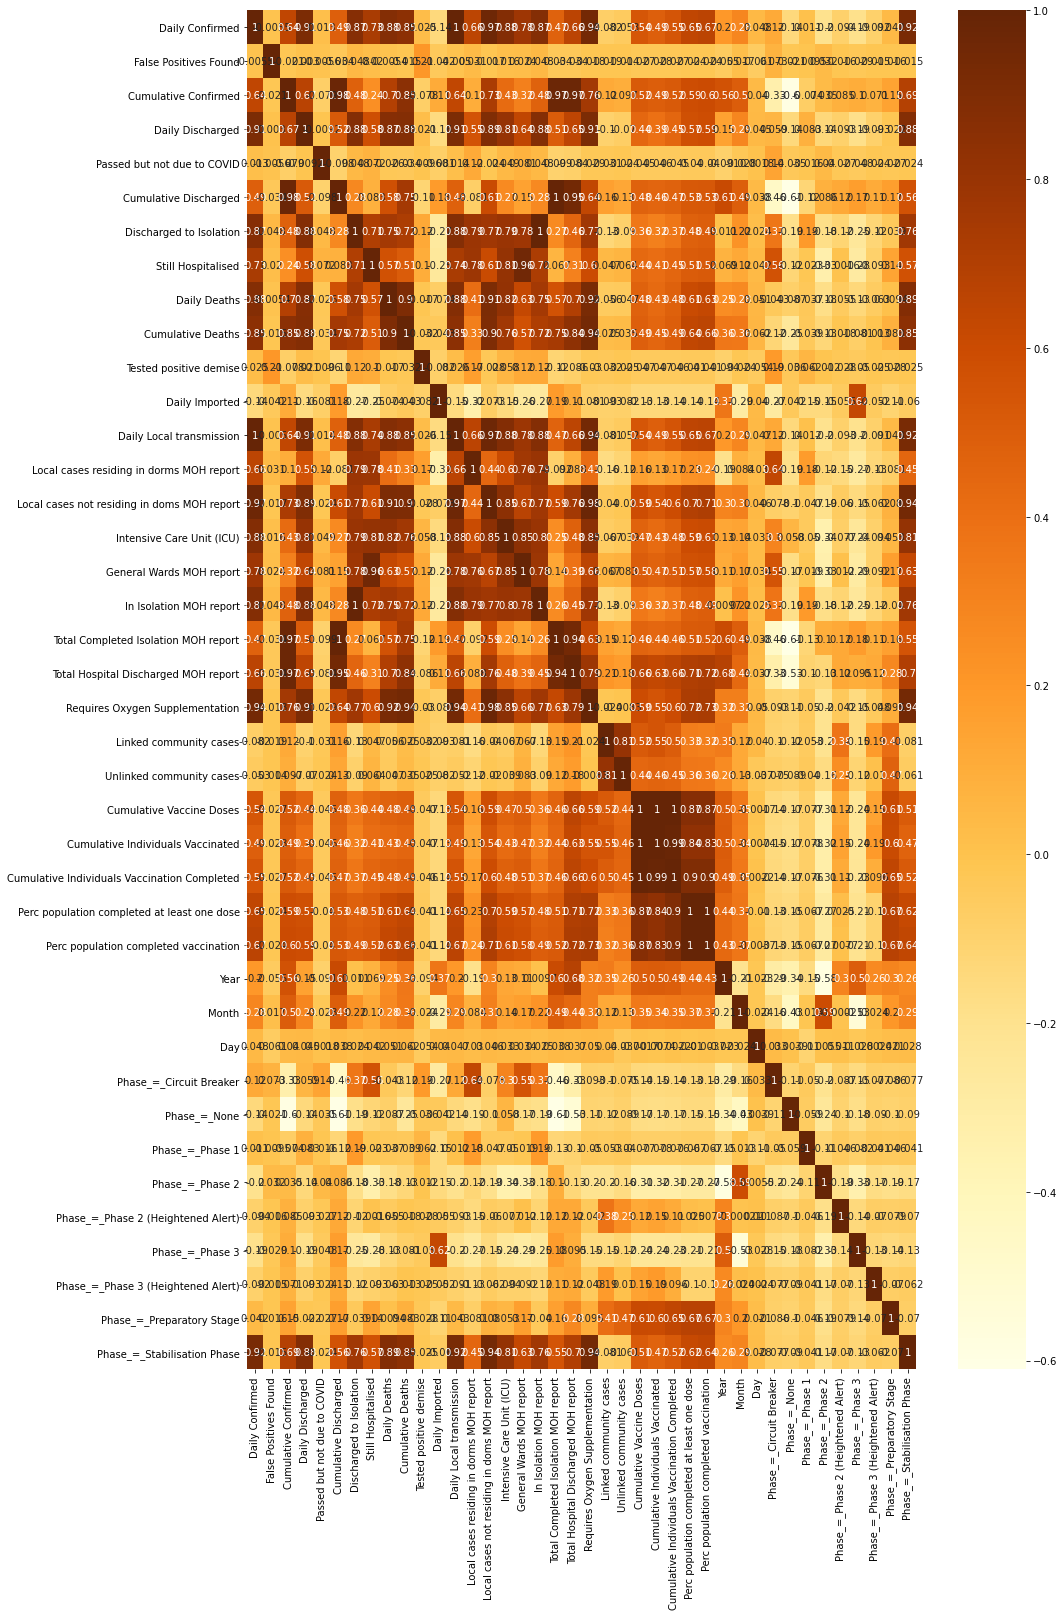

In [12]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [13]:
sg_data_filtered.corr()["Requires Oxygen Supplementation"].sort_values(ascending=False)

Requires Oxygen Supplementation                 1.000000
Local cases not residing in doms MOH report     0.978219
Phase_=_Stabilisation Phase                     0.940046
Daily Confirmed                                 0.939211
Cumulative Deaths                               0.939204
Daily Local transmission                        0.938504
Daily Deaths                                    0.924101
Daily Discharged                                0.909139
Intensive Care Unit (ICU)                       0.853287
Total Hospital Discharged MOH report            0.785340
Discharged to Isolation                         0.772301
In Isolation MOH report                         0.771430
Cumulative Confirmed                            0.758567
Perc population completed vaccination           0.733576
Perc population completed at least one dose     0.716946
General Wards MOH report                        0.664456
Cumulative Discharged                           0.638782
Total Completed Isolation MOH r

# Viewing Chart Pattern

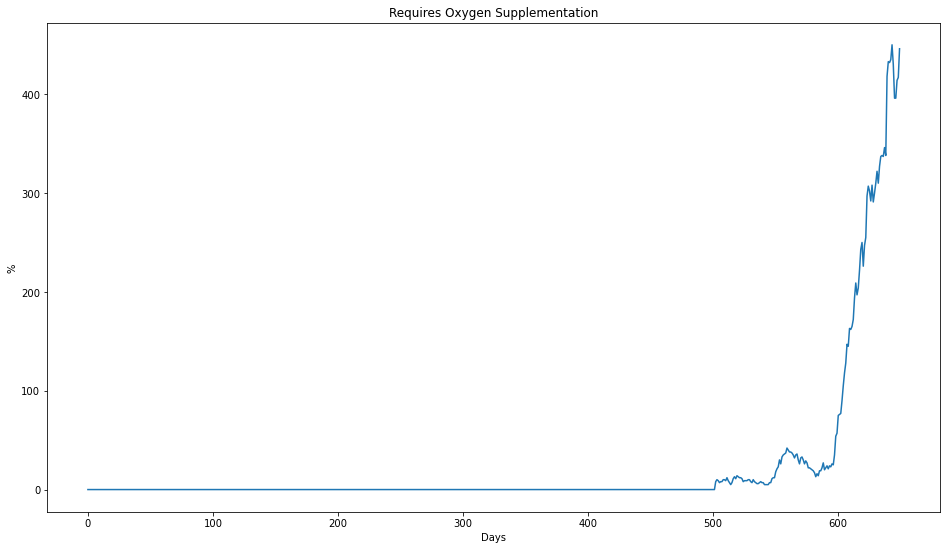

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Requires Oxygen Supplementation"].plot()
plt.title('Requires Oxygen Supplementation')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()

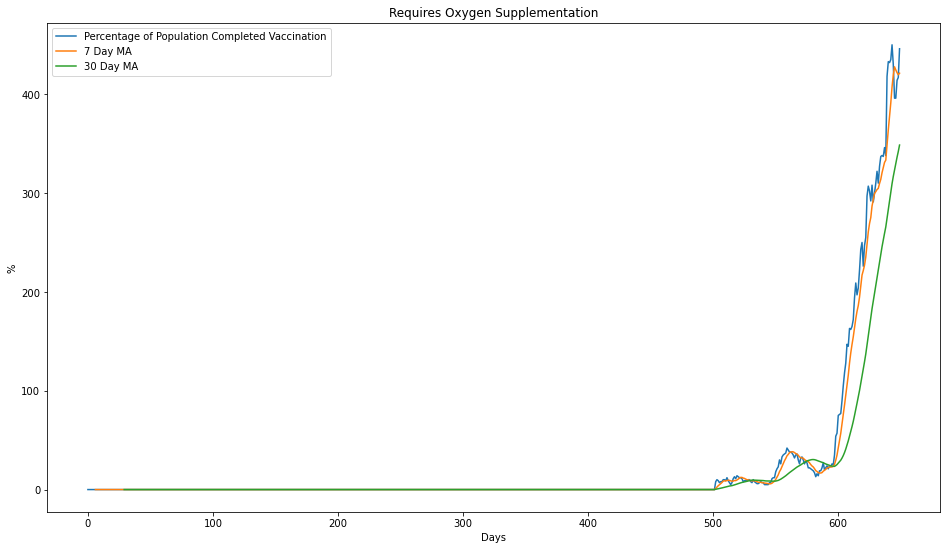

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"], label="Percentage of Population Completed Vaccination")
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Requires Oxygen Supplementation')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()

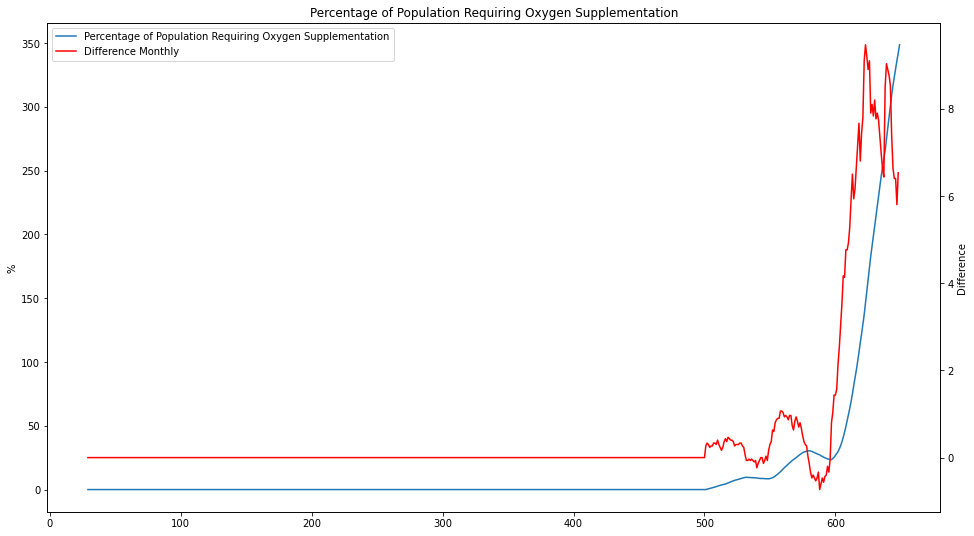

In [16]:
# shows inflection point
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean(), label="Percentage of Population Requiring Oxygen Supplementation")
ax.set_ylabel("%")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Requires Oxygen Supplementation"].rolling(window=30).mean()), label="Difference Monthly", color="red")
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1 + ln2)])
plt.title('Percentage of Population Requiring Oxygen Supplementation')
plt.xlabel('Days')
plt.show()

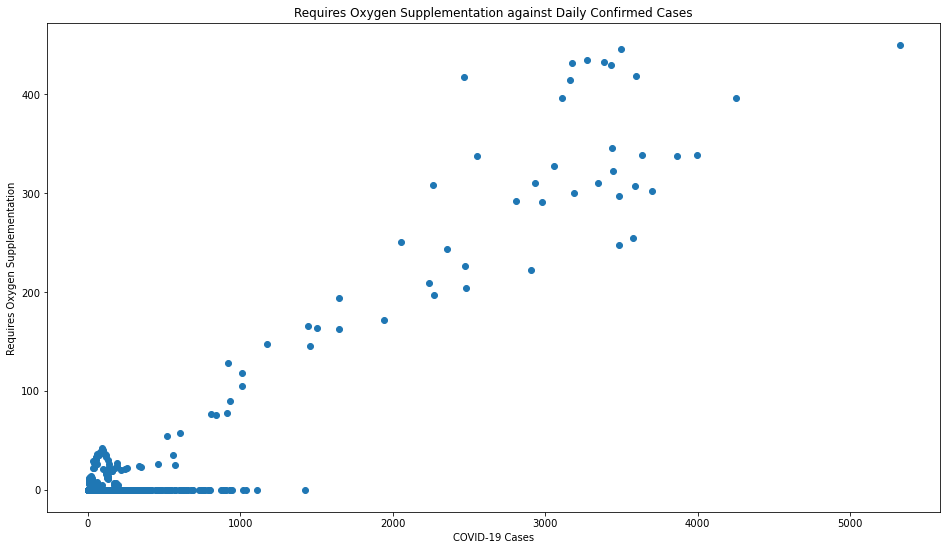

In [17]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Requires Oxygen Supplementation"])
plt.title('Requires Oxygen Supplementation against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('Requires Oxygen Supplementation')
plt.show()

# Train Test Split & KFold Cross Validation

In [18]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Requires Oxygen Supplementation", axis=1)
y = sg_data_filtered["Requires Oxygen Supplementation"]

In [19]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
# strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear regression

In [21]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [22]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 4.18742206996159
MSE: 46.29902166290534
RMSE: 6.804338444177019
R-squared score for train: 0.9933077235971205
Adjusted R-squared score for train: 0.9928798567451331
R-squared score for test: 0.9927545307747397
Adjusted R-squared score for test: 0.9922912958570592
Cross Validation Score: 0.9912


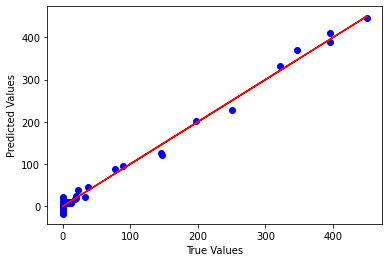

In [23]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

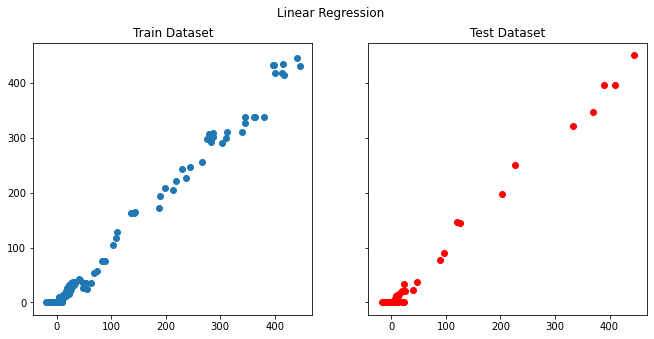

In [24]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [25]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,3.245713e+08
25,Perc population completed at least one dose,5.985950e+02
38,Phase_=_Stabilisation Phase,2.995780e+01
31,Phase_=_None,1.845257e+01
7,Still Hospitalised,5.832756e+00
6,Discharged to Isolation,5.831073e+00
5,Cumulative Discharged,5.659401e+00
9,Cumulative Deaths,5.610579e+00
10,Tested positive demise,3.688465e+00
37,Phase_=_Preparatory Stage,4.049723e-01


# Ridge Regression

In [26]:
# build lasso model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.04872e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [27]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 4.481319783715186
MSE: 63.31137532779297
RMSE: 7.956844558478755
R-squared score for train: 0.9913426957273934
Adjusted R-squared score for train: 0.9907891959460301
R-squared score for test: 0.9900922178251134
Adjusted R-squared score for test: 0.9894587694565551
Cross Validation Score: 0.9889


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.04873e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.37538e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.90622e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.28393e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.08212e-17): result may not be accurate

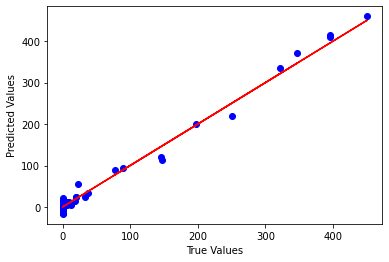

In [28]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

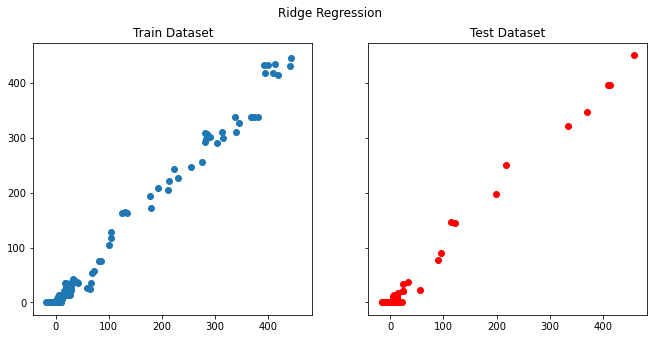

In [29]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [30]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
31,Phase_=_None,20.244667
38,Phase_=_Stabilisation Phase,10.517110
25,Perc population completed at least one dose,7.369740
7,Still Hospitalised,5.939554
6,Discharged to Isolation,5.936529
9,Cumulative Deaths,5.887133
5,Cumulative Discharged,5.782416
33,Phase_=_Phase 2,2.898786
10,Tested positive demise,2.053320
34,Phase_=_Phase 2 (Heightened Alert),1.446197


# Ridge regression important features & future prediction

In [31]:
# taking out the important features based on the importance level mentioned above as well as necessary features (e.g. Year Day Month)
# add in all the phases
important_X = X[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Perc population completed at least one dose","Tested positive demise","Cumulative Deaths","Discharged to Isolation","Still Hospitalised","Cumulative Discharged","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [32]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [33]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 7.487462803999762
MSE: 245.88187351167937
RMSE: 15.680620954275994
R-squared score for train: 0.980738904914482
Adjusted R-squared score for train: 0.9801894600467493
R-squared score for test: 0.9615212269375973
Adjusted R-squared score for test: 0.9604235757250407
Cross Validation Score: 0.974


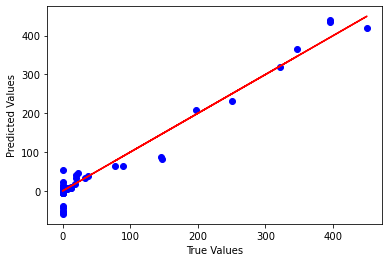

In [34]:
# For test set

# scatter for predictions
plt.scatter(y_test, impt_ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

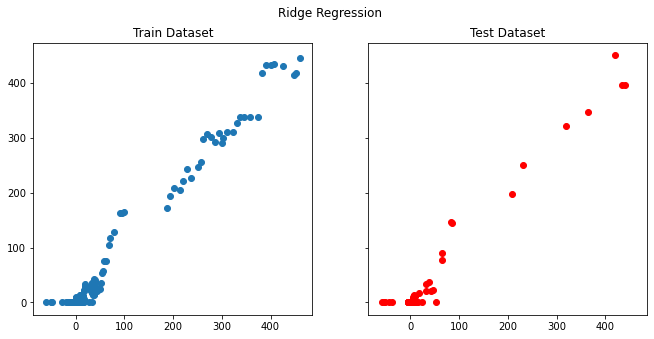

In [35]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(impt_ridge.predict(important_X_train), y_train)
ax[1].scatter(impt_ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

# XGBoost

In [36]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.7,
 'min_child_weight': 2,
 'max_depth': 10,
 'colsample_bytree': 0.9}

In [37]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.8, max_depth=8, colsample_bytree=0.9, min_child_weight=6)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 1.781365863796628
MSE: 30.70413173078332
RMSE: 5.541130907205074
R-squared score for train: 0.9997830691912963
Adjusted R-squared score for train: 0.9997768809907311
R-squared score for test: 0.9951950206817877
Adjusted R-squared score for test: 0.9950579531259591
Cross Validation Score: 0.9951


# Prediction with XGBoost

In [60]:

future_prediction = pd.DataFrame(data={
    "Perc population completed at least one dose":[93],
    "Tested positive demise":[0],
    "Cumulative Deaths":[600],
    "Discharged to Isolation":[45000],
    "Still Hospitalised":[1800],
    "Cumulative Discharged":[250000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)
xgb_fut_pred

array([431.2898], dtype=float32)

In [39]:
xgb_fut_pred

array([431.2898], dtype=float32)